# Devices Exploratory Data Analysis

In [1]:
!pip install -q wordcloud

In [2]:
import sys

sys.path.append('..')

In [3]:
import os
import yaml
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import squarify

from pymongo import MongoClient
from utils import optimize_dtypes

In [4]:
BASE_PATH = '../../'

CONFIG_DIR = os.path.join(BASE_PATH, 'config')
STORAGE_DIR = os.path.join(BASE_PATH, 'storage')
DATA_DIR = os.path.join(BASE_PATH, 'data')

config = yaml.load(open(os.path.join(CONFIG_DIR, 'env.yml')),
                   Loader=yaml.FullLoader)

In [5]:
model = 'devices'
model_storage = os.path.join(STORAGE_DIR, model)

client = MongoClient('mongodb://{}:{}@{}:{}'.format(config['MONGO_USERNAME'], config['MONGO_PASSWORD'],
                                                    config['MONGO_HOST'], config['MONGO_PORT']))
metadata_db = client[config['MONGO_DATABASE']]

model_metadata = metadata_db[model]

In [6]:
mappings = model_metadata.find({}, {'mappings': 1}).next()['mappings']

In [7]:
df = pd.read_parquet(os.path.join(model_storage, 'devices.0.parquet'))

In [8]:
df = optimize_dtypes(df, mappings)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307141 entries, 0 to 307140
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            307141 non-null  uint32        
 1   model         307141 non-null  category      
 2   manufacturer  307141 non-null  category      
 3   brand         307141 non-null  category      
 4   os_version    307141 non-null  category      
 5   is_root       307141 non-null  bool          
 6   created_at    307141 non-null  datetime64[ns]
dtypes: bool(1), category(4), datetime64[ns](1), uint32(1)
memory usage: 6.8 MB


In [10]:
data = df.groupby(df['created_at'].dt.strftime('%Y-%m')).size().reset_index(name='total')
data['cumsum'] = data['total'].cumsum()

fig = go.Figure()

fig.add_trace(go.Scatter(x=data['created_at'], y=data['cumsum'],
                    mode='lines',
                    name='Acumulative'))

fig.add_trace(go.Scatter(x=data['created_at'], y=data['total'],
                    mode='lines',
                    name='Monthly'))

fig.update_yaxes(rangemode='tozero')
fig.update_layout(title='Devices installations over time')
fig.show()

In [11]:
frequency_threshold = 0.01

In [12]:
value_counts = df['brand'].value_counts(normalize=True)
brands_reduce = value_counts[value_counts < frequency_threshold].index

In [13]:
df['brand'] = df['brand'].cat.add_categories('others')
df.loc[df['brand'].isin(brands_reduce), 'brand'] = 'others'
df['brand'] = df['brand'].cat.remove_unused_categories()

In [14]:
def treemap_plot(df, feature, title='', color_pallete=plt.cm.spring):
    stats = df.groupby(feature).size().reset_index(name='counts')
    labels = stats.apply(lambda x: str(
        x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = stats['counts'].values.tolist()
    colors = [color_pallete(i/float(len(labels))) for i in range(len(labels))]

    # Draw Plot
    plt.figure(figsize=(12, 8), dpi=80)
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.7)

    # Decorate
    plt.title(title)
    plt.axis('off')
    plt.show()

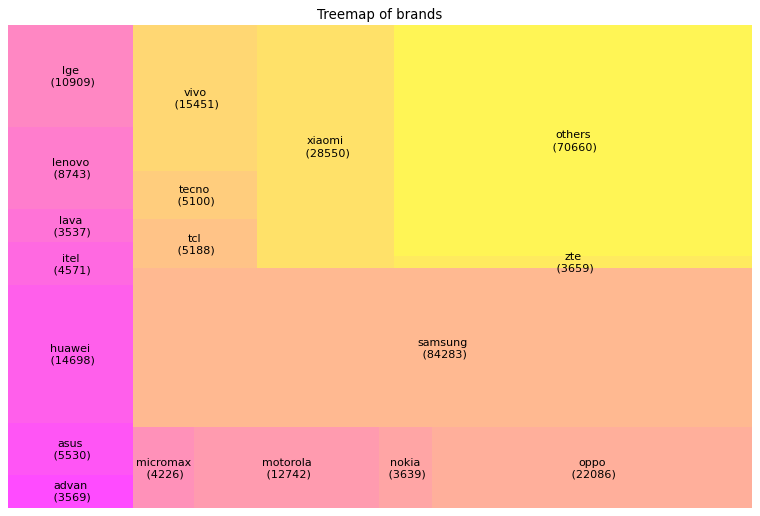

In [15]:
treemap_plot(df, 'brand', 'Treemap of brands')

In [16]:
data = df.groupby('brand').size().reset_index(name='total')
fig = px.pie(data, values='total', names='brand',
             title='Distribution of Brands')
fig.show()

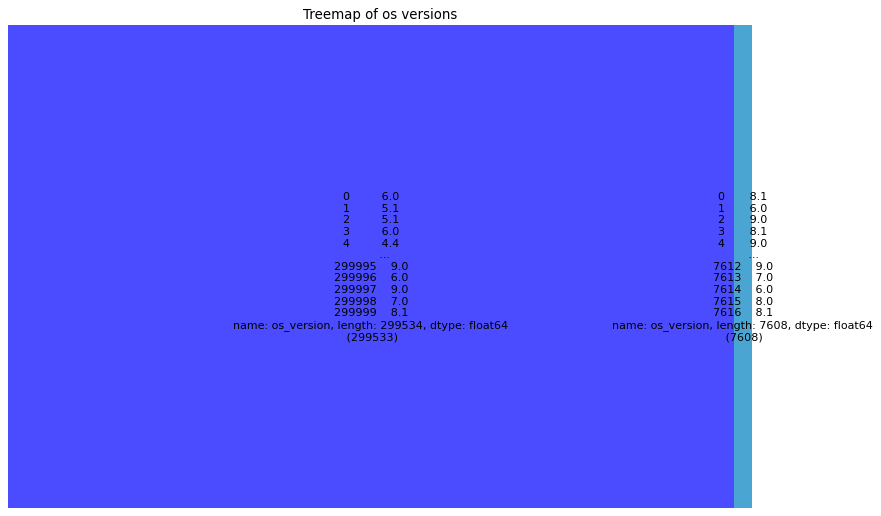

In [17]:
treemap_plot(df, 'os_version', 'Treemap of os versions', plt.cm.winter)

In [18]:
codenames = {'Ice Cream Sandwich': ['4.0'], 'Jelly Bean': ['4.1', '4.2', '4.3'], 'KitKat': ['4.4'],
             'Lollipop': ['5.0', '5.1'], 'Marshmallow': ['6.0'], 'Nougat': ['7.0', '7.1'],
             'Oreo': ['8.0', '8.1'], 'Pie': ['9.0'], 'Android10': ['10.0']}


def get_codename(x):
    x = str(x)
    for k, v in codenames.items():
        if x in v:
            return k
    return None


df['os_codename'] = df['os_version'].map(get_codename).astype('category')

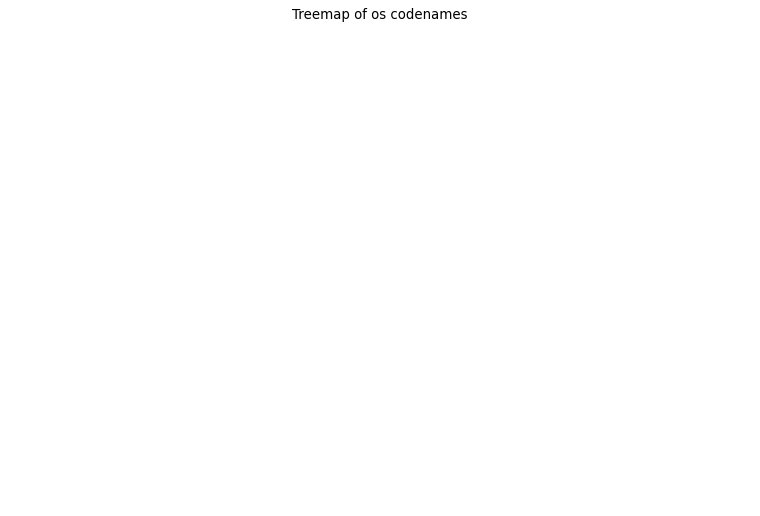

In [19]:
treemap_plot(df, 'os_codename', 'Treemap of os codenames', plt.cm.summer)

In [20]:
stats = df.groupby('is_root').size().reset_index(name='counts')

fig = px.pie(stats, values='counts', names='is_root',
             title='Root and non root Mobile devices')
fig.show()

In [21]:
group = df.groupby([df['created_at'].dt.date, 'os_codename'])
stats = group.size().unstack(fill_value=0).cumsum()
stats = stats.div(stats.sum(axis=1), axis=0) * 100

In [22]:
def stacked_area_plot(df, title=''):
    x = df.index.to_list()

    fig = go.Figure()

    for column in df.columns:
        fig.add_trace(go.Scatter(
            x=x, y=df[column],
            hoverinfo='x+y',
            mode='lines',
            name=column,
            stackgroup='one'  # define stack group
        ))

    fig.update_layout(yaxis_range=(0, 100), title=title)
    fig.show()

In [23]:
stacked_area_plot(stats, 'Distribution over time by OS version')

In [24]:
group = df.groupby([df['created_at'].dt.date, 'brand'])
stats = group.size().unstack(fill_value=0).cumsum()
stats = stats.div(stats.sum(axis=1), axis=0) * 100

In [25]:
stacked_area_plot(stats, title='Distribution over time by brand')

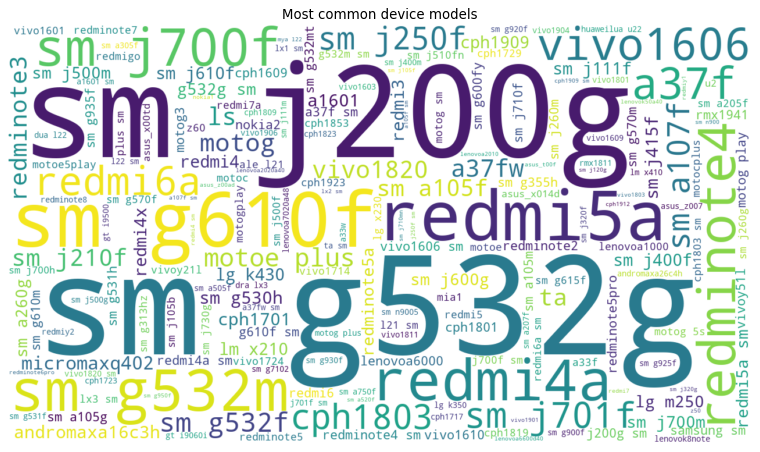

In [26]:
from wordcloud import WordCloud

words = ' '.join(df['model'].str.replace(' ', ''))

wordcloud = WordCloud(width=1280, height=720,
                      max_words=200, background_color='white')

wordcloud.generate(words)

plt.figure(figsize=(12, 8), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most common device models')
plt.axis('off')
plt.show()

In [27]:
s = df['created_at'].dt
data = df.groupby([s.hour, s.day_name()]).size().unstack(fill_value=0)
data = data[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']]

In [28]:
fig = px.imshow(data.values,
                labels=dict(x='Day of Week', y='Hour of Day', color='Installations'),
                x=data.columns.to_list(),
                y=data.index.to_list(),
                color_continuous_scale=px.colors.sequential.Viridis,
                title='When do users install the app'
               )
fig.update_xaxes(side='top')
fig.update_yaxes(nticks=24)
fig.show()